In [ ]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vishalmoreai","key":"3d0aec857c464c4d356c24632f5f7e14"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d endofnight17j03/industry-defect-dataset

 97% 131M/135M [00:04<00:00, 26.2MB/s]
100% 135M/135M [00:04<00:00, 29.9MB/s]


In [ ]:
!unzip industry-defect-dataset.zip

In [7]:
!pip install kerastuner

ERROR: Could not find a version that satisfies the requirement kerastuner (from versions: none)
ERROR: No matching distribution found for kerastuner


In [8]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve
from keras.callbacks import EarlyStopping
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd

In [9]:
base_path = '/content/Industrial-Equipment/'


In [10]:
defected_path = os.path.join(base_path, "Defected")
non_defected_path = os.path.join(base_path, "Non-Defected")

In [11]:
def load_and_resize_images(folder_path, label, target_size=(100, 100), grayscale=True):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith(".png") or filename.endswith(".jpeg"):
            try:
                image = Image.open(os.path.join(folder_path, filename))
                # Resize the image to the target size
                image_resized = image.resize(target_size)
                # Convert the image to grayscale if specified
                if grayscale:
                    image_resized = image_resized.convert('L')
                # Convert the image to a numpy array
                image_array = np.array(image_resized)
                # Add the image and label to the lists
                images.append(image_array)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    return images, labels

In [12]:
# Load and resize images from Defected folder
defected_images, defected_labels = load_and_resize_images(defected_path, label=0)

# Load and resize images from Non-Defected folder
non_defected_images, non_defected_labels = load_and_resize_images(non_defected_path, label=1)

# Check the number of images in each category
print("Number of defected images:", len(defected_images))
print("Number of non-defected images:", len(non_defected_images))

Number of defected images: 2574
Number of non-defected images: 1827


In [13]:
# Concatenate defected and non-defected images and labels
image_data = np.concatenate((defected_images, non_defected_images), axis=0)
label_data = np.concatenate((defected_labels, non_defected_labels), axis=0)

In [14]:
combined_data = list(zip(image_data, label_data))
np.random.shuffle(combined_data)
shuffled_image_data, shuffled_label_data = zip(*combined_data)

# Convert to NumPy arrays
shuffled_image_data = np.array(shuffled_image_data)
shuffled_label_data = np.array(shuffled_label_data)

# Check the shape of the shuffled data
print("Shuffled image data shape:", shuffled_image_data.shape)
print("Shuffled label data shape:", shuffled_label_data.shape)

Shuffled image data shape: (4401, 100, 100)
Shuffled label data shape: (4401,)


In [15]:
train_images, val_images, train_labels, val_labels = train_test_split(shuffled_image_data, shuffled_label_data, test_size=0.2, random_state=42)

In [16]:
train_images = train_images / 255.0
val_images = val_images / 255.0

In [17]:
def build_model(hp):
    model = keras.Sequential()

    # Tune the number of convolutional layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=3, step=1)
    for i in range(num_conv_layers):
        model.add(layers.Conv2D(filters=hp.Int(f'conv_{i}_filter', min_value=32, max_value=128, step=32),
                                kernel_size=(3, 3),
                                padding='same',
                                activation='relu',
                                input_shape=(100, 100, 1)))  # Add input shape with batch dimension
        model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    # Tune the number of dense layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=3, step=1)
    for i in range(num_dense_layers):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_unit', min_value=32, max_value=512, step=32),
                                activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.binary_crossentropy,
                  metrics=['accuracy'])
    return model

In [ ]:
!pip install keras-tuner

In [20]:
import keras_tuner as kt
tuner = kt.RandomSearch(build_model,
                         objective='val_accuracy',
                         max_trials=5,
                         directory="/content/working_folder/",
                         project_name='Industry-Defect')

In [21]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [22]:
tuner.search(train_images, train_labels, epochs=100, validation_data=(val_images, val_labels), callbacks=[early_stopping])

Trial 5 Complete [00h 00m 27s]
val_accuracy: 0.8354142904281616

Best val_accuracy So Far: 0.8592508435249329
Total elapsed time: 00h 01m 51s


In [23]:
# Get the best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 96)        27744     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 25, 25, 96)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 60000)             0         
                                                                 
 dense_2 (Dense)             (None, 320)              

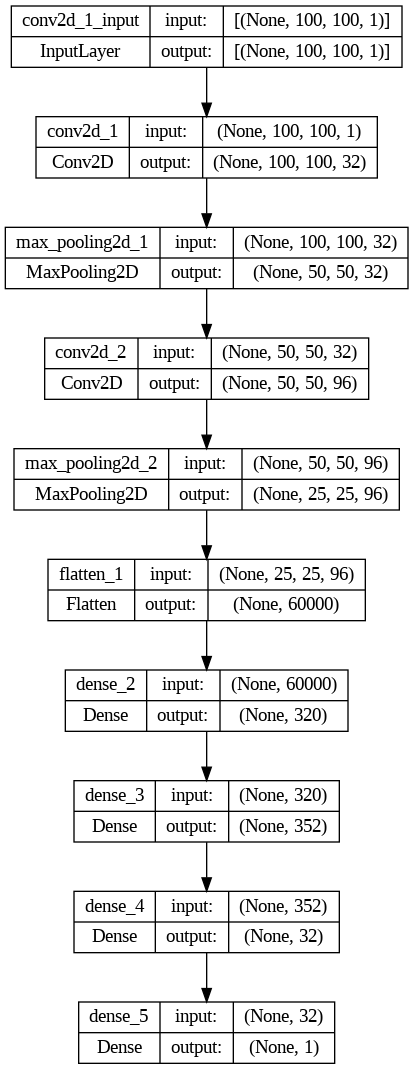

In [25]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [26]:
# Train the model
history = model.fit(train_images, train_labels, epochs=100, validation_data=(val_images, val_labels), callbacks=[early_stopping])

Epoch 1/100
110/110 [==============================] - 4s 23ms/step - loss: 0.5483 - accuracy: 0.7253 - val_loss: 0.4194 - val_accuracy: 0.7821
Epoch 2/100
110/110 [==============================] - 2s 20ms/step - loss: 0.3692 - accuracy: 0.8142 - val_loss: 0.4162 - val_accuracy: 0.7877
Epoch 3/100
110/110 [==============================] - 2s 21ms/step - loss: 0.3052 - accuracy: 0.8509 - val_loss: 0.4067 - val_accuracy: 0.8241
Epoch 4/100
110/110 [==============================] - 2s 19ms/step - loss: 0.2377 - accuracy: 0.8847 - val_loss: 0.3819 - val_accuracy: 0.8422
Epoch 5/100
110/110 [==============================] - 2s 18ms/step - loss: 0.1780 - accuracy: 0.9179 - val_loss: 0.6123 - val_accuracy: 0.8070
Epoch 6/100
110/110 [==============================] - 2s 19ms/step - loss: 0.1129 - accuracy: 0.9557 - val_loss: 0.4874 - val_accuracy: 0.8570
Epoch 7/100
110/110 [==============================] - 2s 20ms/step - loss: 0.0753 - accuracy: 0.9713 - val_loss: 0.4937 - val_accuracy:

In [27]:
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated", category=FutureWarning)

# Set Seaborn style
sns.set(style="whitegrid")

# Get the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

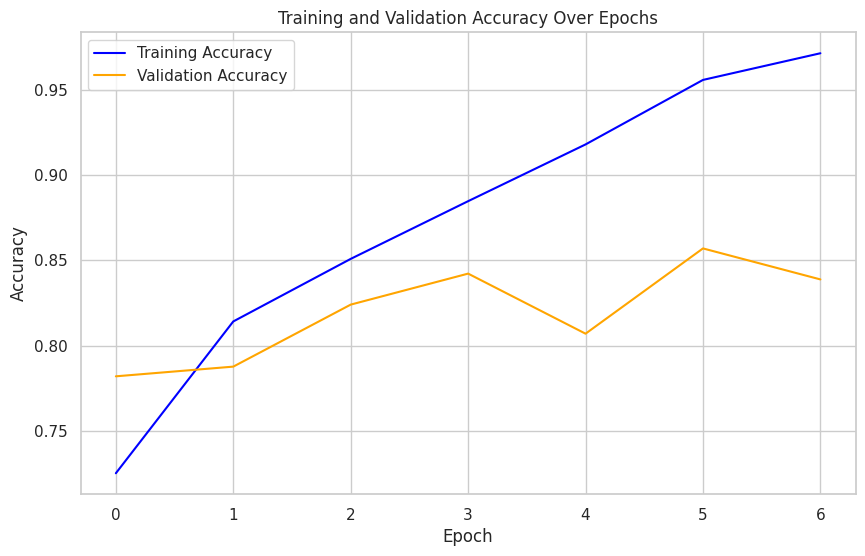

In [28]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

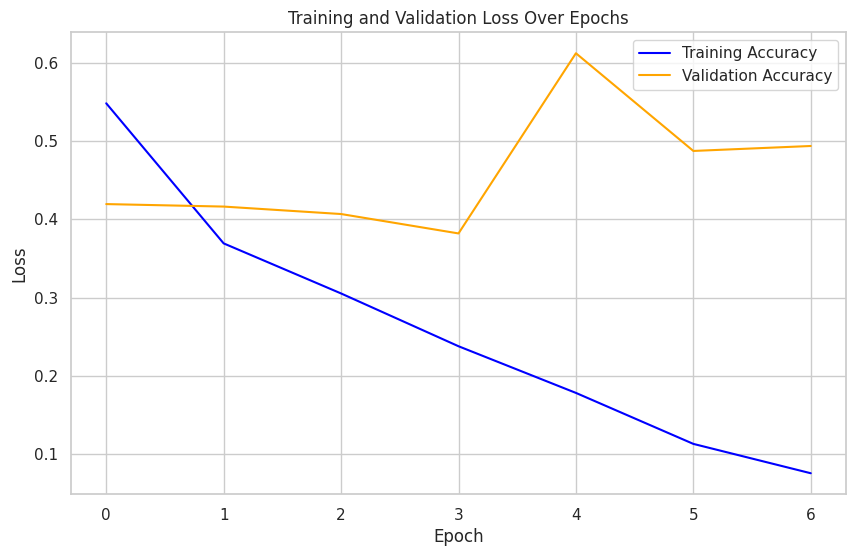

In [29]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.plot(history.history['loss'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_loss'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Evaluate the model on the validation data
evaluation = model.evaluate(val_images, val_labels)

# Print the evaluation results
print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])

28/28 [==============================] - 0s 8ms/step - loss: 0.3819 - accuracy: 0.8422
Evaluation Loss: 0.3818999230861664
Evaluation Accuracy: 0.8422247171401978


In [31]:
predictions = model.predict(val_images)

for i in range(min(5, len(val_images))):
    print("Predicted class probabilities for image", i+1, ":", predictions[i])

28/28 [==============================] - 0s 7ms/step
Predicted class probabilities for image 1 : [0.09564178]
Predicted class probabilities for image 2 : [3.393664e-05]
Predicted class probabilities for image 3 : [0.14038165]
Predicted class probabilities for image 4 : [0.3592586]
Predicted class probabilities for image 5 : [4.5888664e-06]


In [32]:
predicted_labels = (predictions > 0.5).astype("int32")

for i in range(min(5, len(val_images))):
    print("Predicted label for image", i+1, ":", predicted_labels[i])

Predicted label for image 1 : [0]
Predicted label for image 2 : [0]
Predicted label for image 3 : [0]
Predicted label for image 4 : [0]
Predicted label for image 5 : [0]


In [33]:
class_mapping = {0: "Defected", 1: "Non-Defected"}
predictions = model.predict(val_images)
predicted_labels = (predictions > 0.5).astype("int32")

actual_labels = [class_mapping[label] for label in val_labels]

additional_data = {
    "Actual Class Name": actual_labels,
    "Predicted Class Name": [class_mapping[label] for label in predicted_labels.flatten()]
}

data = {
    "Predicted Probabilities": predictions.flatten(),
    "Actual Labels": val_labels,
    "Predicted Labels": predicted_labels.flatten(),
    **additional_data
}

df = pd.DataFrame(data)

28/28 [==============================] - 0s 9ms/step


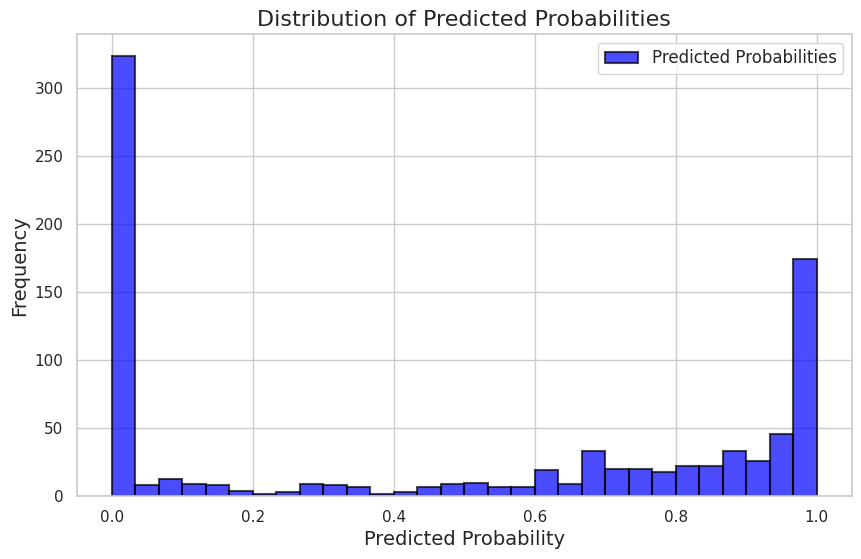

In [34]:
def plot_predicted_probabilities(predicted_probabilities):
    plt.figure(figsize=(10, 6))
    plt.hist(predicted_probabilities, bins=30, alpha=0.7, color='blue', edgecolor='black', linewidth=1.5, label='Predicted Probabilities')
    plt.xlabel('Predicted Probability', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Predicted Probabilities', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_predicted_probabilities(predictions)

In [35]:
styled_df = df.sample(30).style.set_properties(**{'text-align': 'center'}) \
                             .set_caption("Predictions and Actual Labels") \
                             .format({"Predicted Probabilities": "{:.4f}"}) \
                             .background_gradient(cmap='viridis', subset=["Predicted Probabilities"])
styled_df

,Predicted Probabilities,Actual Labels,Predicted Labels,Actual Class Name,Predicted Class Name
640,0.9937,1,1,Non-Defected,Non-Defected
726,0.0004,0,0,Defected,Defected
356,0.4608,0,0,Defected,Defected
419,0.8998,1,1,Non-Defected,Non-Defected
179,0.8014,0,1,Defected,Non-Defected
503,0.0033,0,0,Defected,Defected
783,0.8186,1,1,Non-Defected,Non-Defected
596,0.3214,1,0,Non-Defected,Defected
34,0.9592,0,1,Defected,Non-Defected
45,0.5256,1,1,Non-Defected,Non-Defected


Accuracy: 0.8422247446083996
Precision: 0.7639484978540773
Recall: 0.9246753246753247
F1-score: 0.8366627497062279
ROC AUC score: 0.8514505655634687
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       496
           1       0.76      0.92      0.84       385

    accuracy                           0.84       881
   macro avg       0.85      0.85      0.84       881
weighted avg       0.86      0.84      0.84       881

Confusion Matrix:


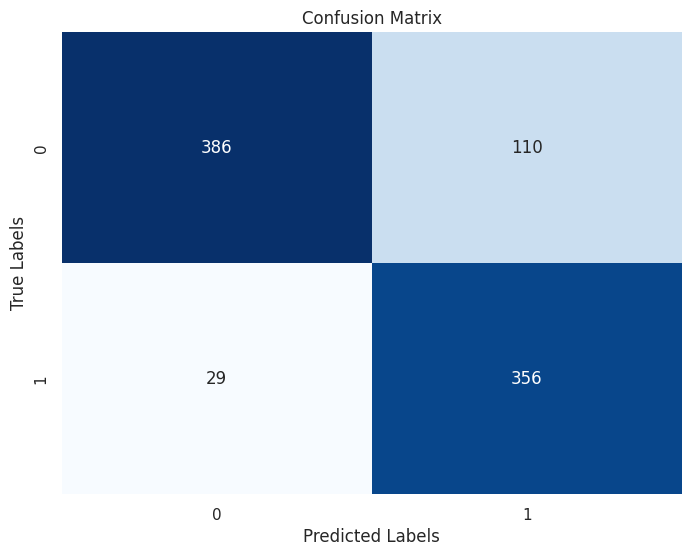

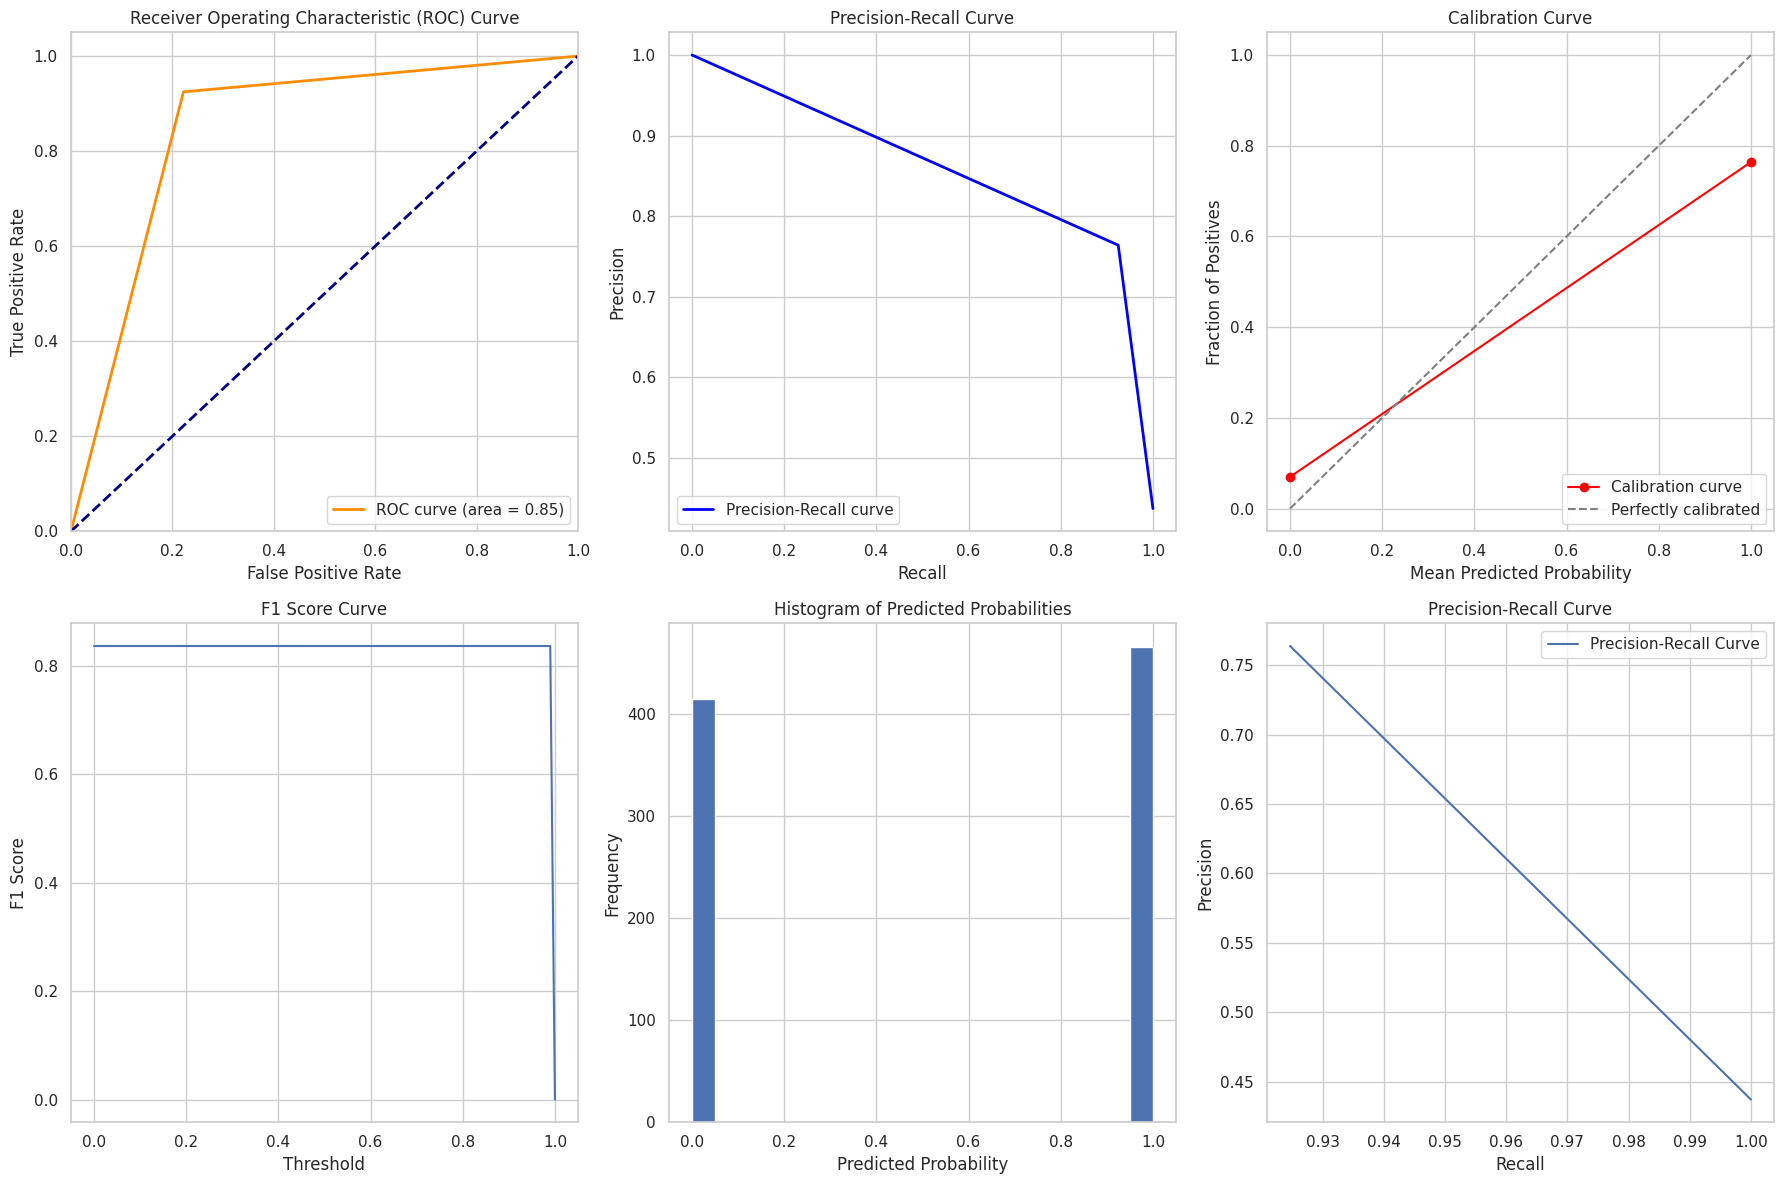

In [36]:
print("==================================================================================")
# Compute accuracy
accuracy = accuracy_score(val_labels, predicted_labels)
print("Accuracy:", accuracy)
print("==================================================================================")
# Compute precision
precision = precision_score(val_labels, predicted_labels)
print("Precision:", precision)
print("==================================================================================")
# Compute recall
recall = recall_score(val_labels, predicted_labels)
print("Recall:", recall)
print("==================================================================================")
# Compute F1-score
f1 = f1_score(val_labels, predicted_labels)
print("F1-score:", f1)
print("==================================================================================")
# Compute ROC AUC score
roc_auc = roc_auc_score(val_labels, predicted_labels)
print("ROC AUC score:", roc_auc)
# Generate classification report
print("==================================================================================")
print("Classification Report:")
print(classification_report(val_labels, predicted_labels))
print("==================================================================================")
# Generate confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(val_labels, predicted_labels)
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
print("==================================================================================")
# Set up subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Compute ROC curve
fpr, tpr, _ = roc_curve(val_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0, 0].legend(loc="lower right")

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(val_labels, predicted_labels)
axes[0, 1].plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend(loc="lower left")

# Plot calibration curve
prob_true, prob_pred = calibration_curve(val_labels, predicted_labels, n_bins=10)
axes[0, 2].plot(prob_pred, prob_true, marker='o', color='red', label='Calibration curve')
axes[0, 2].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
axes[0, 2].set_xlabel('Mean Predicted Probability')
axes[0, 2].set_ylabel('Fraction of Positives')
axes[0, 2].set_title('Calibration Curve')
axes[0, 2].legend(loc="lower right")

# Plot F1 score curve
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(val_labels, (predicted_labels > t).astype(int)) for t in thresholds]
axes[1, 0].plot(thresholds, f1_scores)
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('F1 Score Curve')

# Plot histogram of predicted probabilities
axes[1, 1].hist(predicted_labels, bins=20)
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram of Predicted Probabilities')

# Show precision-recall curve
axes[1, 2].plot(recall[:-1], precision[:-1], label="Precision-Recall Curve")
axes[1, 2].set_xlabel('Recall')
axes[1, 2].set_ylabel('Precision')
axes[1, 2].set_title('Precision-Recall Curve')
axes[1, 2].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [37]:
model.save('/content/working_folder/saved_model.h5')
model.save('/content/working_folder/model.h5')
model_json = model.to_json()
with open("/content/working_folder/model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("/content/working_folder/model_weights.weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step


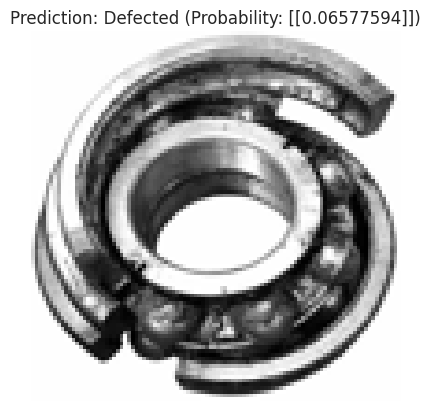

In [40]:
from PIL import Image
import numpy as np

def load_and_preprocess_image(image_path, target_size=(100, 100), grayscale=True):
    # Load image from path
    image = Image.open(image_path)
    # Resize image to target size
    image_resized = image.resize(target_size)
    # Convert image to grayscale if specified
    if grayscale:
        image_resized = image_resized.convert('L')
    # Convert image to numpy array
    image_array = np.array(image_resized)
    # Reshape array to match model's input shape
    image_array = np.expand_dims(image_array, axis=0)
    # Normalize pixel values to range [0, 1]
    image_array = image_array / 255.0
    return image_array

def predict_single_image(model, image_path, threshold=0.5):
    img = load_and_preprocess_image(image_path)
    prediction = model.predict(img)
    class_name = "Defected" if prediction < threshold else "Non-Defected"
    return img, class_name, prediction
def plot_image_with_prediction(image, class_name, prediction):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Prediction: {class_name} (Probability: {prediction})')
    plt.show()

image_path = '/content/Industrial-Equipment/Defected/bearingfailures-1.png'
img, class_name, prediction = predict_single_image(model, image_path)


plot_image_with_prediction(img, class_name, prediction)

1/1 [==============================] - 0s 26ms/step


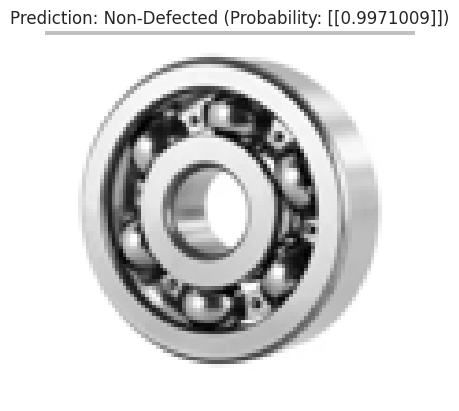

In [41]:
image_path = '/content/Industrial-Equipment/Non-Defected/baring.png'
img, class_name, prediction = predict_single_image(model, image_path)


plot_image_with_prediction(img, class_name, prediction)